===================== Import Packages ====================

In [1]:
import sys, os, pdb, glob
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from astropy.table import Table, join
import linmix
from astroquery.vizier import Vizier
import warnings
from astropy.logger import AstropyWarning
warnings.filterwarnings('ignore', category=AstropyWarning)

===================== Define Functions ===================

In [2]:
def get_data(catalog, join_key='Name', join_type='inner'):

    """
    PURPOSE:    Get data from literature with Vizier

    INPUT:      catalog = ctalog name on Vizier (str)
                join_key = column header to join tables, if multiple (str; optional)
                join_type = way to join tables, if multiple (str; optional)

    OUTPUT:     t = data table (AstroPy Table)

    """

    ### GET FULL CATALOG (ALL COLUMNS, ALL ROWS)
    viz = Vizier(catalog=catalog, columns=['**'])
    viz.ROW_LIMIT = -1
    tv = viz.get_catalogs(catalog)

    ### IF MULTIPLE TABLES, JOIN THEN
    for i, val in enumerate(tv.keys()):
        if i == 0:
            t = tv[val]
        else:
            tt = tv[val]
            if join_key in tt.columns:
                t = join(t, tt, join_type=join_type, keys=join_key)

    return t

In [3]:
def do_mc(x_data, x_err, y_data, y_err, ind_dd):

    ### MAKE DETECTION ARRAY (1=DET, 0=NON-DET)
    ddet = np.repeat(1, len(y_data))
    ddet[~ind_dd] = 0

    ### calculate linmix
    lmcens  = linmix.LinMix(x_data, y_data, x_err, y_err, delta=ddet, K=3)
    lmcens.run_mcmc(silent=True)
    A, Ae = np.mean(lmcens.chain['alpha']), np.std(lmcens.chain['alpha'])
    B, Be = np.mean(lmcens.chain['beta']), np.std(lmcens.chain['beta'])
    D, De = np.mean(np.sqrt(lmcens.chain['sigsqr'])), np.std(np.sqrt(lmcens.chain['sigsqr']))

    print('\n =====================================')
    print("\n LinMix_Err terms:")
    print("    A  = {0:.2f}".format(A) + "+/- {0:.2f}".format(Ae))
    print("    B  = {0:.2f}".format(B) + "+/- {0:.2f}".format(Be))
    print("    D  = {0:.2f}".format(D) + "+/- {0:.2f}\n".format(De))

    ### print to file
    # pname = '../mcdust/B' + str(Band) + '_D' + str(DistLup3) + '_b' + str(BetaDust)
    # rn = len(glob.glob(pname + '/*rn.out'))
    # fname = pname + "/" + "{0:02d}".format(rn) + '_rn.out'
    # np.savetxt(fname, np.c_[lmcens.chain['alpha'], lmcens.chain['beta'], lmcens.chain['sigsqr']], fmt='%1.2e')

    pars = np.array([A, Ae, B, Be, D, De])

    return pars, x_data, x_err

In [4]:
def assign_mstar(ms, e_ms):

    # INDEX STARS WITHOUT MASS MEASUREMENTS
    f_ms = np.copy(ms.mask)
    ind_nomass = np.where(ms.mask == True)

    ### DISTRIBUTION OF LUPUS STELLAR MASSES
    ### FROM Mortier+2011 (2011MNRAS.418.1194M) FIGURE 9
    hist_values = np.array([ 5., 5., 12., 12., 12., 9., 9., 9., 1., 1., 1., 1., 1., 1.])
    log_mstar_bins = np.array([-1.05, -0.95, -0.85, -0.75, -0.65, -0.55, -0.45, 
                               -0.35, -0.25, -0.15, -0.05,  0.05,  0.15,  0.25])
    
    ### RANDOMLY ASSIGN VALUE FROM RANGE SEEN IN LUPUS (MORTIER+2011)
    ### USE MEDIAN FRACTIONAL ERROR OF MSTAR FOR LUPUS SOURCES WITH KNOWN MSTAR 
    mstar_probs = hist_values / np.sum(hist_values)
    randm = 10**(np.random.choice(log_mstar_bins, len(ind_nomass[0]), p=list(mstar_probs)))
    for i, val in enumerate(ind_nomass[0]):
        ms[val] = "{0:.2f}".format(randm[i])
        e_ms[val] = "{0:.2f}".format(randm[i] * .20) 

    return ms, e_ms, ~f_ms

========================== Code ==========================

In [5]:
#### LOAD IN LUPUS DATA
T = get_data("J/ApJ/828/46")

In [6]:
#### GET STELLAR MASSES FOR THOSE WITH UNKNOWN VALUES
mstar, e_mstar, ind_mstar = assign_mstar(T['Mass'], T['e_Mass'])
T['Mass'], T['e_Mass'] = mstar, e_mstar

In [7]:
### INDEX (NON-)DETECTIONS
ind_dd = T['F890'] / T['e_F890'] >= 3.0
ind_nd = T['F890'] / T['e_F890'] < 3.0

In [8]:
### DEFINE PLOT VARIABLES
x_data_lin = np.copy(T['Mass'])
y_data_lin = np.copy(T['MDust'])
y_data_lin[ind_nd] = 3.0 * np.copy(T['e_MDust'][ind_nd])
y_err_lin = np.sqrt((T['e_MDust'])**2 + (0.1 * T['e_MDust'])**2)
x_err_lin = np.copy(T['e_Mass'])

In [9]:
### CONVERT TO LOG SCALE
x_data = np.log10(x_data_lin)
y_data = np.log10(y_data_lin)
y_err  = np.array(0.434 * (y_err_lin / y_data_lin))
x_err  = np.array(0.434 * (x_err_lin / x_data_lin))

## GET MCMC FIT WITH LINMIX
pars, x_data, x_err = do_mc(x_data, x_err, y_data, y_err, ind_dd)
A, Ae, B, Be, D, De = pars[0], pars[1], pars[2], pars[3], pars[4], pars[5]
yfit = A + B * xfit

([<matplotlib.axis.YTick at 0x144f61970>,
 [Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2')])

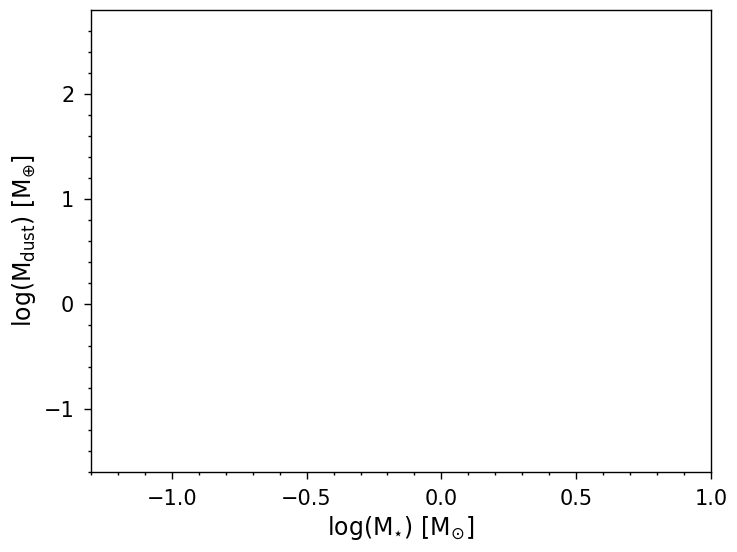

In [10]:
### SET UP PLOT
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
mpl.rc('xtick.major', size=5, pad=7, width=1)
mpl.rc('ytick.major', size=5, pad=7, width=1)
mpl.rc('axes', linewidth=1)
mpl.rc('lines', markersize=5)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
xmin, xmax, ymin, ymax = -1.3, 0.6, -1.6, 2.8
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.tick_params(which='minor', axis='x', length=2.5, color='k', width=1)
ax.tick_params(which='minor', axis='y', length=2.5, color='k', width=1)
ax.minorticks_on()
ax.set_xlabel(r'$\mathregular{log(M_{\star})}$' + ' ' + r'$\mathregular{[M_{\odot}]}$', fontsize=17)
ax.set_ylabel(r'$\mathregular{log(M_{dust})}$' + ' ' + r'$\mathregular{[M_{\oplus}]}$', fontsize=17)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(np.arange(-1, 0.5+1, 0.5))
plt.yticks(np.arange(-1, 2+1, 1.0))

In [11]:
### PLOT DETECTIONS WITH ERROR BARS
### ONLY PLOT THOSE WITH KNOWN STELLAR MASSES
ax.errorbar(x_data[ind_dd & ind_mstar], y_data[ind_dd & ind_mstar], yerr=y_err[ind_dd & ind_mstar], xerr=x_err[ind_dd & ind_mstar], ms=0, ecolor='lightgray', zorder=3, elinewidth=0.5, ls='none', capsize=2)
ax.scatter(x_data[ind_dd & ind_mstar], y_data[ind_dd & ind_mstar], marker='o', facecolor='lightblue', s=40, edgecolor='black', lw=1, zorder=4)

In [12]:
### PLOT NON-DETECTIONS
### ONLY PLOT THOSE WITH KNOWN STELLAR MASSES
ax.scatter(x_data[ind_nd & ind_mstar], y_data[ind_nd & ind_mstar], marker='v', facecolor='lightgray', s=40, edgecolor='gray', lw=1, zorder=3)

In [13]:
### PLOT LINE FITS TO POPULATIONS
xfit = np.log10(np.arange(10, 1e4) / 1e3)
ax.plot(xfit, 1.20 + 1.80 * xfit,color='lightblue', linewidth=2, zorder=2, label='Lupus')
ax.plot(xfit, 1.20 + 1.70 * xfit, color='darkviolet', linewidth=2, alpha=0.3, zorder=1, label='Taurus')
ax.plot(xfit, 0.80 + 2.40 * xfit, color='green', linewidth=2, alpha=0.3, zorder=1, label='Upper Sco')
# ax.plot(xfit, 1.45 + 1.80 * xfit,color='lightblue',linewidth=2, alpha=0.3, zorder=1, label='Lupus - Only Known Stellar Masses')

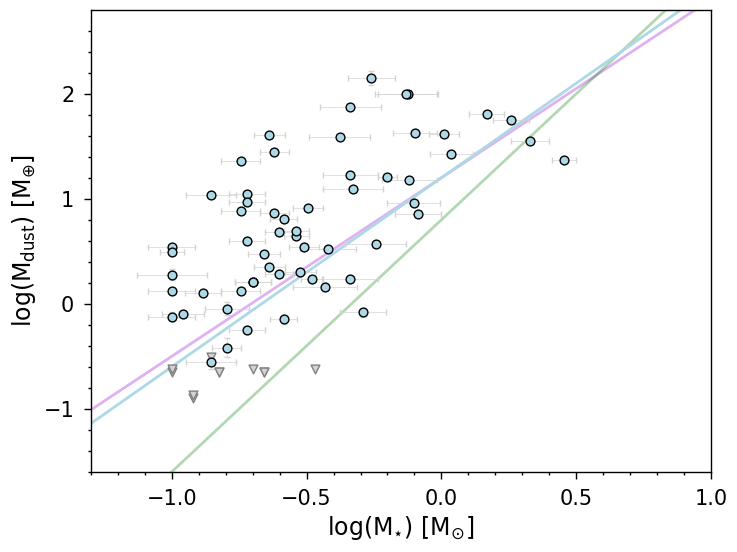

In [14]:
### SAVE FIGURE
fig.savefig('../output/figure_06.png', bbox_inches='tight', dpi=100)
fig

In [15]:
plt.close('all')